<a href="https://www.kaggle.com/code/davidecortonesi/data-cleaning-extraction-and-visualization?scriptVersionId=142314281" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# TO INSTALL LIBRARIES
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os

# ITERATE THROUGH DIRECTORIES AND FILES IN '/KAGGLE/INPUT'
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/mobile-prices-2023/mobile_prices_2023.csv


In [2]:
# CALL THIS DATASET df
df = pd.read_csv("/kaggle/input/mobile-prices-2023/mobile_prices_2023.csv")

In [3]:
# SHOW ME THE STARTING DATASET
df.head()

,Phone Name,Rating ?/5,Number of Ratings,RAM,ROM/Storage,Back/Rare Camera,Front Camera,Battery,Processor,Price in INR,Date of Scraping
0,"POCO C50 (Royal Blue, 32 GB)",4.2,"33,561",2 GB RAM,32 GB ROM,8MP Dual Camera,5MP Front Camera,5000 mAh,"Mediatek Helio A22 Processor, Upto 2.0 GHz Pro...","₹5,649",2023-06-17
1,"POCO M4 5G (Cool Blue, 64 GB)",4.2,"77,128",4 GB RAM,64 GB ROM,50MP + 2MP,8MP Front Camera,5000 mAh,Mediatek Dimensity 700 Processor,"₹11,999",2023-06-17
2,"POCO C51 (Royal Blue, 64 GB)",4.3,"15,175",4 GB RAM,64 GB ROM,8MP Dual Rear Camera,5MP Front Camera,5000 mAh,Helio G36 Processor,"₹6,999",2023-06-17
3,"POCO C55 (Cool Blue, 64 GB)",4.2,"22,621",4 GB RAM,64 GB ROM,50MP Dual Rear Camera,5MP Front Camera,5000 mAh,Mediatek Helio G85 Processor,"₹7,749",2023-06-17
4,"POCO C51 (Power Black, 64 GB)",4.3,"15,175",4 GB RAM,64 GB ROM,8MP Dual Rear Camera,5MP Front Camera,5000 mAh,Helio G36 Processor,"₹6,999",2023-06-17


In [4]:
# SHOW ME THE PERCENTAGE OF NaNs PRESENT IN EACH COLUMN
def missing_data(df):
    total_missing = df.isnull().sum().sort_values(ascending = False)
    Percentage = (total_missing / len(df)) * 100
    summary_df = pd.concat([total_missing, Percentage], axis=1, keys=['Data Missing', 'Data Percentage Missing'])
    return summary_df

missing_data_df = missing_data(df)
missing_data_df.style.background_gradient(cmap='Greys')

,Data Missing,Data Percentage Missing
Front Camera,401,21.840959
ROM/Storage,174,9.477124
Processor,55,2.995643
Battery,10,0.544662
Back/Rare Camera,9,0.490196
Phone Name,0,0.000000
Rating ?/5,0,0.000000
Number of Ratings,0,0.000000
RAM,0,0.000000
Price in INR,0,0.000000


In [5]:
# CREATE A COLUMN NAMED "Price in Euro"
df["Price in INR"] = df["Price in INR"].str.replace("₹", "").str.replace(",", "")  # Remove "₹" and "," from the "Price in INR" column
df["Price in INR"] = df["Price in INR"].astype("int")  # Convert the "Price in INR" column to an integer
df["Price in Euro"] = df["Price in INR"] / 92  # I have used an exchange rate of ₹/€ = 92/1
df['Price in Euro'] = df['Price in Euro'].round(2)  # Formula to round the values in the 'Price in Euro' column to the nearest hundredth

In [6]:
# RENAME COLUMN
df.rename(columns={'Rating ?/5': 'Rating 0/5'}, inplace=True)

In [7]:
# REMOVE "," FROM "Number of Ratings" COLUMN
df["Number of Ratings"] = df["Number of Ratings"].str.replace(",", "")

In [8]:
# CREATE A NEW COLUMN "BRAND" TO INDICATE THE MANUFACTURER BRAND OF THE PHONE
df['Phone Name'] = df['Phone Name'].astype(str)
df['BRAND'] = df['Phone Name'].str.split().str[0]

In [9]:
# THIS CODE WAS USED TO ANALYZE EACH COLUMN TO PERFORM DATA CLEANING ACTIVITIES. ONLY THIS EXAMPLE OF HOW THE WORK WAS DONE WILL BE KEPT.
df['BRAND'].value_counts()[:40]

SAMSUNG     240
realme      233
vivo        216
Nokia       144
APPLE       134
POCO        120
OnePlus     120
Infinix     120
OPPO        120
Redmi       104
MOTOROLA     78
Mi           45
Xiaomi       28
Lenovo       24
Alcatel      24
Google       17
REDMI        12
Huawei       11
Apple        10
Moto          8
Realme        7
Motorola      6
Nothing       5
Nexus         3
A10E          2
a             2
�9A           2
10A           1
Name: BRAND, dtype: int64

In [10]:
# DATA CLEANING OF "BRAND" COLUMN
df['BRAND'] = df['BRAND'].replace({"APPLE": "Apple", "apple": "Apple", "Nexus": "Google", "realme": "Realme", "vivo": "Vivo", "SAMSUNG": "Samsung", "10A": "Samsung", "Mi": "Xiaomi", "MOTOROLA": "Motorola", "Moto": "Motorola", "A10E": "Samsung", "a": "Samsung", "�9A": "Samsung", "10A": "Samsung"})

In [11]:
# RESULT AFTER DATA CLEANING OF BRAND VALUE
df['BRAND'].value_counts()[:40]

Samsung     247
Realme      240
Vivo        216
Apple       144
Nokia       144
POCO        120
OnePlus     120
Infinix     120
OPPO        120
Redmi       104
Motorola     92
Xiaomi       73
Alcatel      24
Lenovo       24
Google       20
REDMI        12
Huawei       11
Nothing       5
Name: BRAND, dtype: int64

In [12]:
# I NOTICED THAT SOME VALUES IN THE RAM COLUMN REFER TO THE ROM, WITH THIS CODE I AM MOVING THESE VALUES TO THE "STORAGE" COLUMN.
def move_ROM_from_RAM(row):
    if row['RAM'] is not None and row['RAM'].endswith("ROM"):
        row['ROM/Storage'] = row['RAM']
        row['RAM'] = None
    return row

df = df.apply(move_ROM_from_RAM, axis=1)
print(df.columns)

# I'M REMOVING "RAM" WORD FROM THE "RAM" COLUMN
df['RAM'] = df['RAM'].fillna('None').apply(lambda x: x.replace('RAM', ''))

# FORMULA TO CONVERT VALUES EXPRESSED IN MEGABYTES (MB) AND GIGABYTES (GB) INTO NUMERICAL VALUES WITH A REFERENCE SIZE OF 1 GB:
mb_to_gb = {
    "MB": 0.001,
    "GB": 1
}

def convert_ram_to_gb(ram_value):
    value, unit = ram_value.split()
    return float(value) * mb_to_gb[unit]

def check_ram_value(value):
    valid_values = ['MB', 'GB']
    for valid_value in valid_values:
        if valid_value in value:
            return value
    return None

df['RAM'] = df['RAM'].apply(check_ram_value)

# I'M REMOVING UNWANTED STRINGS
unwanted_strings = ['Expandable Upto 16 GB', 'Expandable Upto 2 GB']
df['RAM'] = df['RAM'].apply(lambda x: None if x in unwanted_strings else x)
df.dropna(subset=['RAM'], inplace=True)

# THIS CODE CREATES A NEW COLUMN 'RAM GB' THAT CONTAINS VALUES FROM THE 'RAM' COLUMN CONVERTED INTO NUMERICAL VALUES (EXPRESSED IN GB)
df['RAM GB'] = df['RAM'].apply(convert_ram_to_gb)
df.drop(columns=['RAM'], inplace=True)

Index(['Phone Name', 'Rating 0/5', 'Number of Ratings', 'RAM', 'ROM/Storage',
       'Back/Rare Camera', 'Front Camera', 'Battery', 'Processor',
       'Price in INR', 'Date of Scraping', 'Price in Euro', 'BRAND'],
      dtype='object')


In [13]:
# I'M REMOVING "ROM" WORD FROM THE "ROM/Storage" COLUMN
df['ROM/Storage'] = df['ROM/Storage'].fillna('None').apply(lambda x: x.replace('ROM', ''))

# FORMULA TO CONVERT VALUES EXPRESSED IN KB, MB, GB, TB INTO NUMERICAL VALUES WITH A REFERENCE SIZE OF 1 GB:
byte_to_gb = {
    "KB": 1e-6,
    "MB": 0.001,
    "GB": 1,
    "TB": 1000
}

def convert_rom_to_gb(rom_value):
    value, unit = rom_value.split()
    return float(value) * byte_to_gb[unit]

def check_rom_value(value):
    valid_values = ['MB', 'GB', "KB", "TB"]
    for valid_value in valid_values:
        if valid_value in value:
            return value
    return None   

df['ROM/Storage'] = df['ROM/Storage'].apply(check_rom_value)

# I'M REMOVING UNWANTED STRING, BECAUSE IT CANNOT EXIST A SMARTPHONE WITH NO STORAGE, SO I WILL DROP THAT ROW
unwanted_string = ['0 GB']
df['ROM/Storage'] = df['ROM/Storage'].apply(lambda x: None if x in unwanted_string else x)
df.dropna(subset=['ROM/Storage'], inplace=True)

# THIS CODE CREATES A NEW COLUMN 'STORAGE GB' THAT CONTAINS VALUES FROM THE 'ROM/Storage' COLUMN CONVERTED INTO NUMERICAL VALUES (EXPRESSED IN GB)
df['Storage GB'] = df['ROM/Storage'].apply(convert_rom_to_gb)
df.drop(columns=['ROM/Storage'], inplace=True)

In [14]:
# I'M REMOVING "mAh" WORD FROM THE "Battery" COLUMN 
df['Battery'] = df['Battery'].fillna('None').apply(lambda x: x.replace('mAh', ''))

# I'M CONVERTING TO NUMERIC ALL THE VALUES CONTAINED IN THE 'Battery' COLUMN, DROPPING THE ROWS CONTAINING NON-NUMERIC VALUES.
df['Battery'] = pd.to_numeric(df['Battery'], errors='coerce')
df = df.dropna(subset=['Battery'])

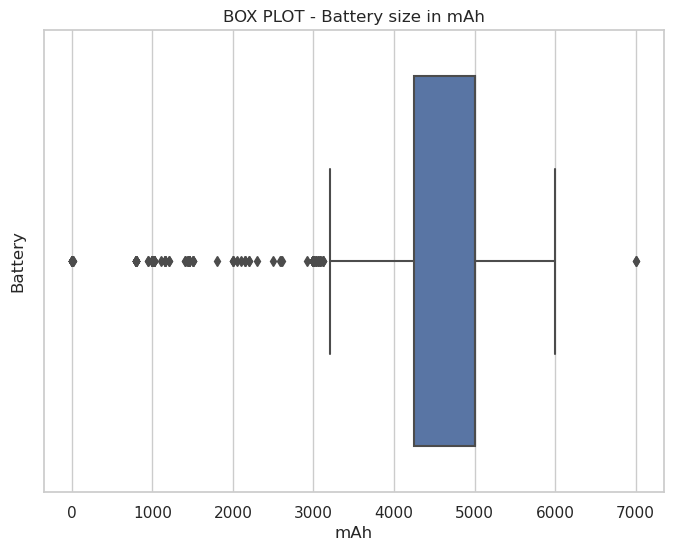

In [15]:
# BOXPLOT BEFORE CHECKING BATTERY SIZE
plt.figure(figsize=(8, 6))
sns.set(style="whitegrid") 
sns.boxplot(x=df['Battery'])
plt.title("BOX PLOT - Battery size in mAh")
plt.xlabel("mAh")
plt.ylabel("Battery")
plt.show()

In [16]:
# BY CHECKING FOR OUTLIERS, IT'S POSSIBLE TO IDENTIFY AN ERROR. BATTERIES OF SUCH SMALL SIZES CANNOT EXIST. FOR THIS REASON, I WILL REMOVE THESE ANOMALIES
df = df[df['Battery'] >= 50]

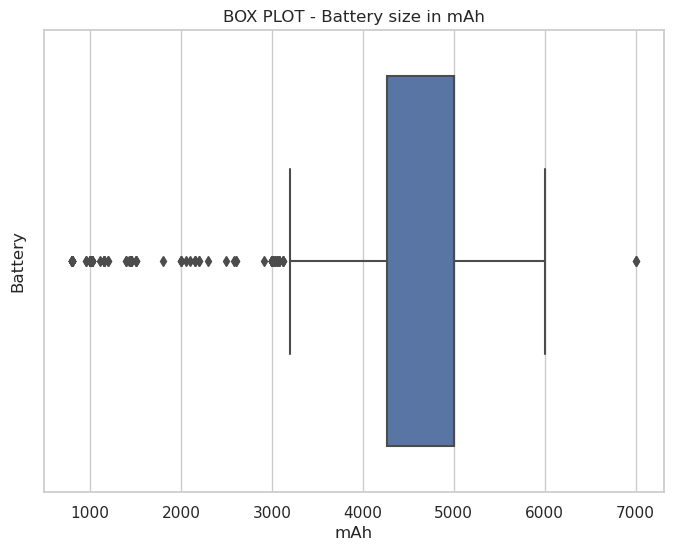

In [17]:
# BOXPLOT AFTER CHECKING BATTERY SIZE
plt.figure(figsize=(8, 6))
sns.set(style="whitegrid") 
sns.boxplot(x=df['Battery'])
plt.title("BOX PLOT - Battery size in mAh")
plt.xlabel("mAh")
plt.ylabel("Battery")
plt.show()

In [18]:
# CLEANING PROCESSOR COLUMN
df['Processor'] = df['Processor'].str.replace(r'\s*Processor.*', '', regex=True)

In [19]:
# SINCE THIS COLUMN HAS A SINGLE VALUE, THE BEST THING TO DO IS TO DROP THE COLUMN.
df['Date of Scraping'].value_counts()[:10]

2023-06-17    1614
Name: Date of Scraping, dtype: int64

In [20]:
# CODE TO DROP "Date of Scraping" COLUMN
df = df.drop("Date of Scraping", axis=1)

In [21]:
# THE PURPOSE OF THIS WORK IS TO PERFORM DATA CLEANING ON A DATASET TO SUBSEQUENTLY UTILIZE IT FOR PREDICTIVE ANALYSIS. GIVEN THAT 20% OF THE FRONT CAMERA COLUMN CONSISTS OF NaN VALUES, I FIND IT MORE REASONABLE TO DROP THIS COLUMN, RATHER THAN DROPPING THE ROWS CONTAINING THESE VALUES.
df = df.drop("Front Camera", axis=1)

In [22]:
# SHOW ME THE PERCENTAGE OF NaNs PRESENT IN EACH COLUMN
def missing_data(df):
    total_missing = df.isnull().sum().sort_values(ascending=False)
    percentage = (total_missing / len(df)) * 100
    summary_df = pd.concat([total_missing, percentage], axis=1, keys=['Data Missing', 'Data Percentage Missing'])
    return summary_df

missing_data_df = missing_data(df)
missing_data_df.style.background_gradient(cmap='Greys')

,Data Missing,Data Percentage Missing
Processor,1,0.061958
Phone Name,0,0.000000
Rating 0/5,0,0.000000
Number of Ratings,0,0.000000
Back/Rare Camera,0,0.000000
Battery,0,0.000000
Price in INR,0,0.000000
Price in Euro,0,0.000000
BRAND,0,0.000000
RAM GB,0,0.000000


In [23]:
# THERE IS ONLY ONE REMAINING NaN. THIS CODE WILL DROP ALL THE NaN VALUES PRESENT IN THE DATAFRAME.
df = df.dropna()

In [24]:
# I NOTICED THAT THE DATASET CONTAINED DUPLICATE PHONES THAT HAVE DIFFERENCES ONLY REGARDING THEIR COLOR. SO I CLEANED THE BRAND PHONE COLUMN IN ORDER TO RUN THE CODE TO REMOVE THE DUPLICATE VALUES.
df["Phone Name"] = df["Phone Name"].str.split("(").str[0].str.strip()
# CODE TO DROP DUPLICATES IN "Phone Name" COLUMN
df = df.drop_duplicates(subset='Phone Name')

In [25]:
# THIS IS THE DATASET AFTER THE CLEANING OPERATION!
df.head()

,Phone Name,Rating 0/5,Number of Ratings,Back/Rare Camera,Battery,Processor,Price in INR,Price in Euro,BRAND,RAM GB,Storage GB
0,POCO C50,4.2,33561,8MP Dual Camera,5000.0,Mediatek Helio A22,5649,61.40,POCO,2.0,32.0
1,POCO M4 5G,4.2,77128,50MP + 2MP,5000.0,Mediatek Dimensity 700,11999,130.42,POCO,4.0,64.0
2,POCO C51,4.3,15175,8MP Dual Rear Camera,5000.0,Helio G36,6999,76.08,POCO,4.0,64.0
3,POCO C55,4.2,22621,50MP Dual Rear Camera,5000.0,Mediatek Helio G85,7749,84.23,POCO,4.0,64.0
12,POCO M5,4.2,7572,50MP + 2MP Depth Sensor + 2MP Macro Sensor,5000.0,Mediatek Helio G99,8999,97.82,POCO,4.0,64.0


In [26]:
# CLEANING PROCESSOR COLUMN. SOME ROWS CONTAIN 'WARRANTY' INSTEAD OF THE PROCESSOR IN THE PROCESSOR COLUMN. SINCE THIS IS AN IMPORTANT COLUMN, I'VE DECIDED TO KEEP IT AND REPLACE THE ENTIRE ROW WITH THE WORD 'OTHER'.
for index, row in df.iterrows():
    if 'warranty' in row['Processor']:
        df.at[index, 'Processor'] = 'Other'

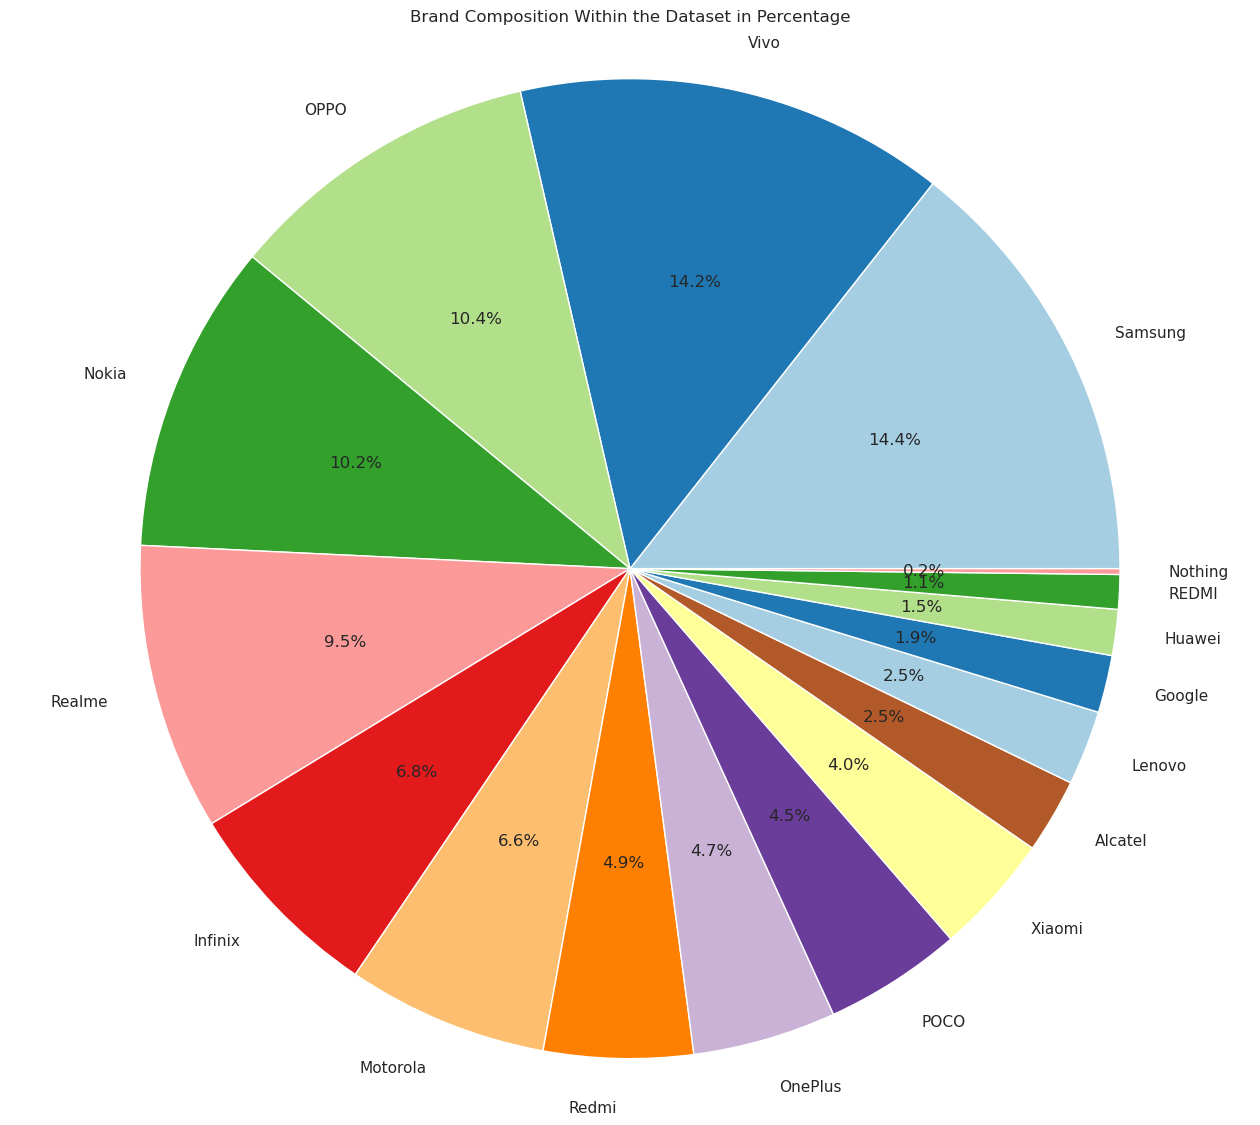

In [27]:
# PLOTTING OF A PIE CHART TO DISPLAY THE PERCENTAGE COMPOSITION OF SMARTPHONE MANUFACTURER BRANDS WITHIN THE DATASET.
brand_counts = df["BRAND"].value_counts()
plt.figure(figsize=(16, 14))
plt.pie(brand_counts, labels=brand_counts.index, autopct="%1.1f%%", colors=plt.cm.Paired.colors)
plt.axis("equal")  
plt.title("Brand Composition Within the Dataset in Percentage")
plt.show()

In [28]:
# FINDING TOP 10 SMARTPHONES
df['Number of Ratings'] = df['Number of Ratings'].astype(int)  # Convert 'Number of Ratings' column to integers
filtered_df = df[df['Number of Ratings'] >= 500]  
sorted_df = filtered_df.sort_values(by='Rating 0/5', ascending=False)  

top_10_smartphones = sorted_df.head(10)  
top_10_smartphones

,Phone Name,Rating 0/5,Number of Ratings,Back/Rare Camera,Battery,Processor,Price in INR,Price in Euro,BRAND,RAM GB,Storage GB
594,SAMSUNG Galaxy S23 5G,4.6,1645,50MP + 10MP + 12MP,3900.0,Qualcomm Snapdragon 8 Gen 2,79999,869.55,Samsung,8.0,256.0
1616,OnePlus 7T,4.6,9598,48 MP + 12 MP + 16 MP,3800.0,Qualcomm® Snapdragon™ 855 Plus,38500,418.48,OnePlus,8.0,256.0
164,realme C21Y,4.6,91242,13MP + 2MP + 2MP,5000.0,Unisoc T610,7499,81.51,Realme,3.0,32.0
1538,OnePlus 11R 5G,4.6,2193,50MP Rear Camera,5000.0,Other,44989,489.01,OnePlus,16.0,256.0
1662,Nexus 6P,4.5,4082,12.3MP Rear Camera,3450.0,Qualcomm Snapdragon 810 v2.1 64-bit,42999,467.38,Google,3.0,64.0
189,realme C31,4.5,48051,13MP + 2MP + 0.3MP,5000.0,Unisoc T612,8049,87.49,Realme,3.0,32.0
1205,Redmi K20 Pro,4.5,15363,48MP + 13MP + 8MP,4000.0,Qualcomm Snapdragon 855,31999,347.82,Redmi,8.0,256.0
1044,vivo Z1Pro,4.5,360377,16MP + 2MP + 8MP,5000.0,Qualcomm Snapdragon 712 AIE Octa Core 2.3GHz,15990,173.80,Vivo,4.0,64.0
1043,vivo X80,4.5,841,50MP + 12MP + 12MP,4500.0,Mediatek Dimensity 9000,54999,597.82,Vivo,8.0,128.0
792,OPPO A53,4.5,82838,13MP + 2MP + 2MP,5000.0,Qualcomm Snapdragon 460,11990,130.33,OPPO,4.0,64.0


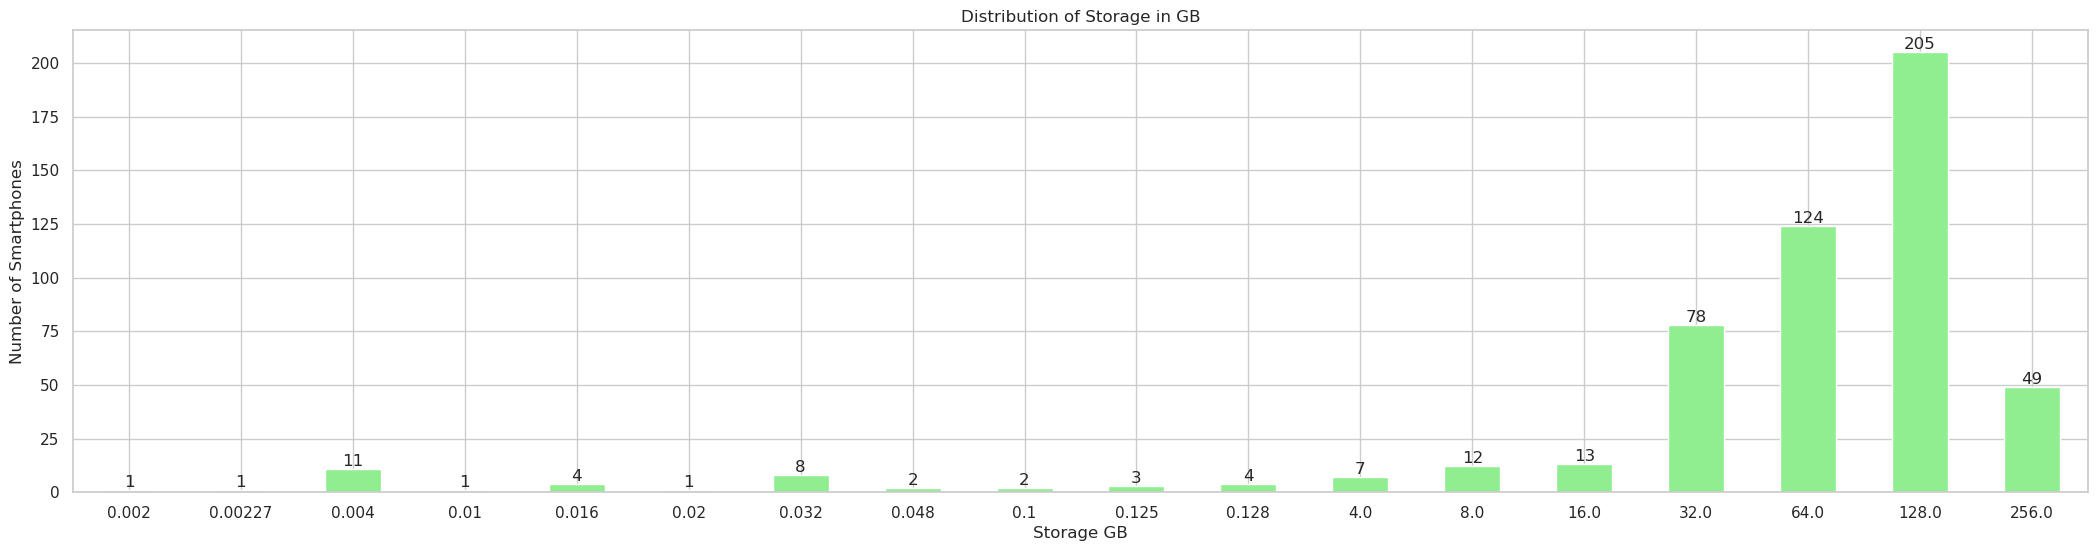

In [29]:
# I'M REMOVING A VERY SMALL VALUE THAT WAS CAUSING ISSUES WITH DATA VISUALIZATION
df = df[df['Storage GB'] >= 0.001]
ROM_distribution = df['Storage GB'].value_counts().sort_index()

# CREATE A BAR PLOT
plt.figure(figsize=(26, 6))
ROM_distribution.plot(kind='bar', color='lightgreen')
plt.title('Distribution of Storage in GB')
plt.xlabel('Storage GB')
plt.ylabel('Number of Smartphones')
plt.xticks(rotation=0)

# ADD COUNTS AS TEXT BELOW EACH BAR
for i, count in enumerate(ROM_distribution):
    plt.text(i, count + 0.1, str(count), ha='center', va='bottom')

plt.show()

In [30]:
# MUST-HAVE INFORMATION FOR ANY DATASET
statistics = df.describe()
statistics.loc['median'] = df.median(numeric_only=True)
statistics

,Rating 0/5,Number of Ratings,Battery,Price in INR,Price in Euro,RAM GB,Storage GB
count,526.000000,526.000000,526.000000,526.000000,526.000000,526.000000,526.000000
mean,4.165779,39736.241445,4317.984791,19091.901141,207.520361,5.110868,94.200725
std,0.558440,97544.763159,1222.881211,15371.781416,167.084551,2.996732,68.928696
min,0.000000,0.000000,800.000000,1250.000000,13.590000,0.004000,0.002000
25%,4.100000,879.500000,4000.000000,9999.000000,108.680000,3.000000,32.000000
50%,4.300000,5735.000000,5000.000000,14999.000000,163.030000,4.000000,64.000000
75%,4.400000,25132.750000,5000.000000,23967.500000,260.515000,8.000000,128.000000
max,4.800000,945051.000000,7000.000000,124999.000000,1358.680000,16.000000,256.000000
median,4.300000,5735.000000,5000.000000,14999.000000,163.030000,4.000000,64.000000


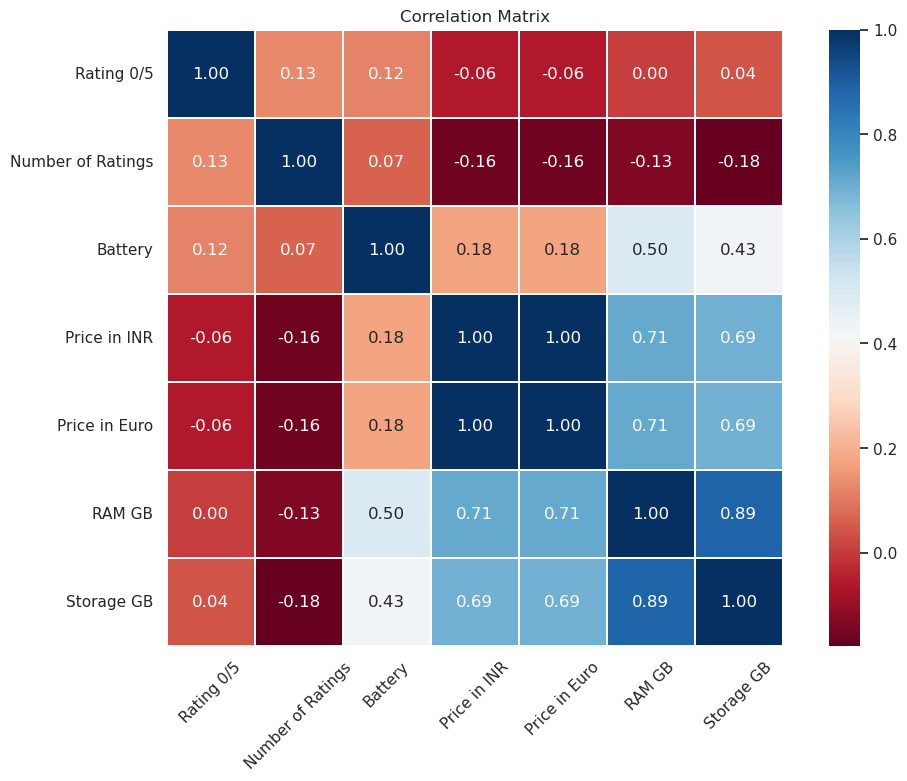

The correlation matrix plot shows that the price of smartphones has a statistically significant positive correlation with the variables (RAM GB) and (Storage GB). In other words, as these two variables increase, the price of smartphones also increases.


In [31]:
# PLOT A CORRELATION MATRIX
corrmat = df.corr(numeric_only=True)
plt.figure(figsize=(12, 8))
sns.heatmap(corrmat, linewidths=0.1, annot=True, cmap="RdBu", fmt=".2f", square=True, cbar=True)
plt.title('Correlation Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()
print("The correlation matrix plot shows that the price of smartphones has a statistically significant positive correlation with the variables (RAM GB) and (Storage GB). In other words, as these two variables increase, the price of smartphones also increases.")